# CatBoost Model

## Step 1: Import packages and set working directory

In [1]:
# Import packages
import optuna
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import catboost as cb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Optional Code: Here's a format for setting working directory, change as needed
import os
# os.chdir('/path/to/the/project')
os.chdir('/Users/zihanji/Desktop/DS340W')

## Step 2: Load the final cleaned data

In [3]:
data_final = pd.read_csv('./project/volume/data/processed/data_final.csv')

## Step 3: Building the CatBoost model

In [4]:
# Split the data to features and result
x = data_final.drop('SalePrice', axis = 1)
y = data_final['SalePrice']

In [5]:
# Split the data to train and test, with test size being 20% of the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [6]:
# Fit the model to built a prediction for x test
CatBoost = cb.CatBoostRegressor(logging_level = 'Silent')
CatBoost.fit(x_train, y_train)
CatBoost_pred = CatBoost.predict(x_test)

## Step 4: Check for scores

In [7]:
# Check for the score of the prediction
CatBoost_score = CatBoost.score(x_train, y_train)
print('CatBoost Model Score: ', round(CatBoost_score, 3))

# R squared value
r2 = r2_score(y_test, CatBoost_pred)
print('R Squared: ', round(r2, 3))

# Adjusted R squared value
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print('Adjusted R Squared: ', round(adj_r2, 3))

# Mean squared error
mean_sq = mean_squared_error(y_test, CatBoost_pred)
print('Mean Squared Error: ', round(mean_sq, 3))

# Root mean squared error
root_mean_sq = np.sqrt(mean_sq)
print('Root Mean Squared Error: ', round(root_mean_sq, 3))

# Mean absolute error
mean_ab = mean_absolute_error(y_test, CatBoost_pred)
print('Mean Absolute Error: ', round(mean_ab, 3))

# Cross validation (or accuracy)
cv = cross_val_score(CatBoost, x, y, scoring = 'r2', cv = 5)
print('Accuracy: ', round(cv.mean() * 100, 3), '%')

CatBoost Model Score:  0.986
R Squared:  0.949
Adjusted R Squared:  0.943
Mean Squared Error:  0.009
Root Mean Squared Error:  0.097
Mean Absolute Error:  0.068
Accuracy:  91.38 %


## Step 5: Create visuals

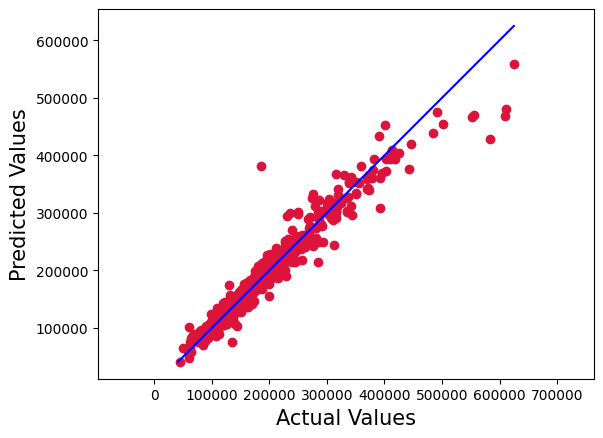

In [8]:
actual_price = np.expm1(y_test)
predicted_price = np.expm1(CatBoost_pred)

# Create a scatter plot
plt.scatter(actual_price, predicted_price, c = 'crimson')

# Draw the line of perfect prediction (where actual = predicted)
p1 = max(max(predicted_price), max(actual_price))
p2 = min(min(predicted_price), min(actual_price))
plt.plot([p1, p2], [p1, p2], 'b-')

# Add labels
plt.xlabel('Actual Values', fontsize = 15)
plt.ylabel('Predicted Values', fontsize = 15)

# Make sure the axes are scaled equally
plt.axis('equal')

plt.show()

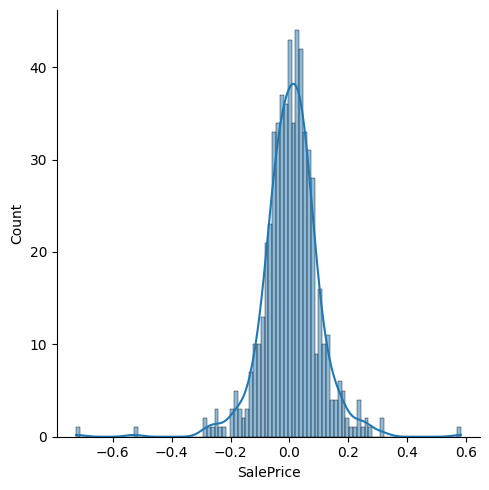

In [9]:
# Distribution of residuals (difference between actual and predicted value)
sb.displot((y_test - CatBoost_pred), bins = 100, kde = True)

## Step 6: Hyperparameter tuning (optuna)

In [10]:
def objective(trial):
    # Define hyperparameter search space
    parameters = {'iterations': trial.suggest_int('iterations', 100, 500),
                  'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
                  'depth': trial.suggest_int('depth', 1, 10),
                  'subsample': trial.suggest_uniform('subsample', 0.05, 1.0),
                  'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.05, 1.0),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)}
    # Train catboost model
    model = cb.CatBoostRegressor(**parameters)
    model.fit(x_train, y_train, eval_set = [(x_test, y_test)], verbose = False)
    # Evaluate model
    predict = model.predict(x_test)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    return rmse

In [11]:
# Run optuna optimization
study = optuna.create_study(direction = 'minimize')  # Minimize RMSE
study.optimize(objective, n_trials = 50)

# Print best hyperparameters
print('Best RMSE: ', study.best_value)
print('Best Hyperparameters: ', study.best_params)

[I 2025-04-10 23:10:00,075] A new study created in memory with name: no-name-8c5021e0-5458-4e8a-b2fe-c409c8b7938e
/var/folders/bc/6ybxr1xs1f98kjg2pl98nqlc0000gn/T/ipykernel_37520/2799082157.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.05, 1.0),
/var/folders/bc/6ybxr1xs1f98kjg2pl98nqlc0000gn/T/ipykernel_37520/2799082157.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.05, 1.0),
[I 2025-04-10 23:10:00,282] Trial 0 finished with value: 0.1742585596359653 and parameters: {'iterations': 461, 'learning_rate': 0.011246680958273143, 'depth': 1, 'subsample': 0.31507840453942315, 'colsample_

Best RMSE:  0.1005739589390547
Best Hyperparameters:  {'iterations': 403, 'learning_rate': 0.09967147161809234, 'depth': 7, 'subsample': 0.501400826388817, 'colsample_bylevel': 0.6149921675922263, 'min_data_in_leaf': 37}


In [12]:
# Built a CatBoost model with the new hyperparameter option
# {'iterations': 403, 'learning_rate': 0.09967147161809234, 'depth': 7, 'subsample': 0.501400826388817, 
# 'colsample_bylevel': 0.6149921675922263, 'min_data_in_leaf': 37}
cb_mod = cb.CatBoostRegressor(iterations = 403, learning_rate = 0.09967147161809234, depth = 7, 
                              subsample = 0.501400826388817, colsample_bylevel = 0.6149921675922263, 
                              min_data_in_leaf = 37, logging_level = 'Silent')
cb_mod.fit(x_train, y_train)
cb_pred = cb_mod.predict(x_test)

## Step 7: Check for scores

In [13]:
# Check for the score of the prediction
cb_mod_score = cb_mod.score(x_train, y_train)
print('CatBoost Model Score: ', round(cb_mod_score, 3))

# R squared value
r2 = r2_score(y_test, CatBoost_pred)
print('R Squared: ', round(r2, 3))

# Adjusted R squared value
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print('Adjusted R Squared: ', round(adj_r2, 3))

# Mean squared error
mean_sq = mean_squared_error(y_test, CatBoost_pred)
print('Mean Squared Error: ', round(mean_sq, 3))

# Root mean squared error
root_mean_sq = np.sqrt(mean_sq)
print('Root Mean Squared Error: ', round(root_mean_sq, 3))

# Mean absolute error
mean_ab = mean_absolute_error(y_test, CatBoost_pred)
print('Mean Absolute Error: ', round(mean_ab, 3))

# Cross validation (or accuracy)
cv = cross_val_score(cb_mod, x, y, scoring = 'r2', cv = 5)
print('Accuracy: ', round(cv.mean() * 100, 3), '%')

CatBoost Model Score:  0.988
R Squared:  0.949
Adjusted R Squared:  0.943
Mean Squared Error:  0.009
Root Mean Squared Error:  0.097
Mean Absolute Error:  0.068
Accuracy:  91.222 %


## Step 8: Create visuals

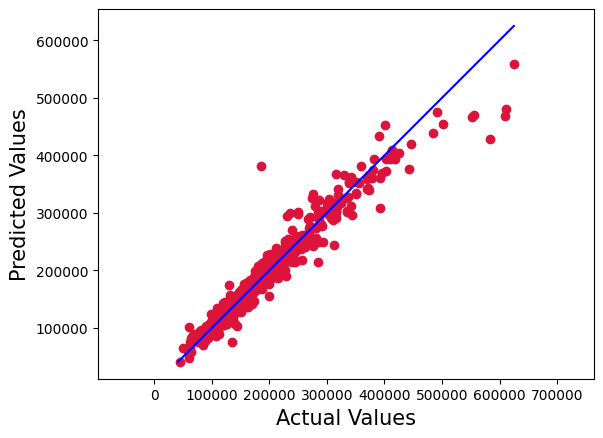

In [14]:
actual_price = np.expm1(y_test)
predicted_price = np.expm1(CatBoost_pred)

# Create a scatter plot
plt.scatter(actual_price, predicted_price, c = 'crimson')

# Draw the line of perfect prediction (where actual = predicted)
p1 = max(max(predicted_price), max(actual_price))
p2 = min(min(predicted_price), min(actual_price))
plt.plot([p1, p2], [p1, p2], 'b-')

# Add labels
plt.xlabel('Actual Values', fontsize = 15)
plt.ylabel('Predicted Values', fontsize = 15)

# Make sure the axes are scaled equally
plt.axis('equal')

plt.show()

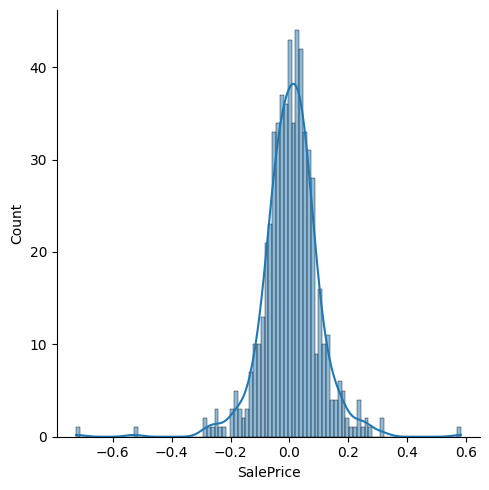

In [15]:
# Distribution of residuals (difference between actual and predicted value)
sb.displot((y_test - CatBoost_pred), bins = 100, kde = True)

## Step 9: Check feature important

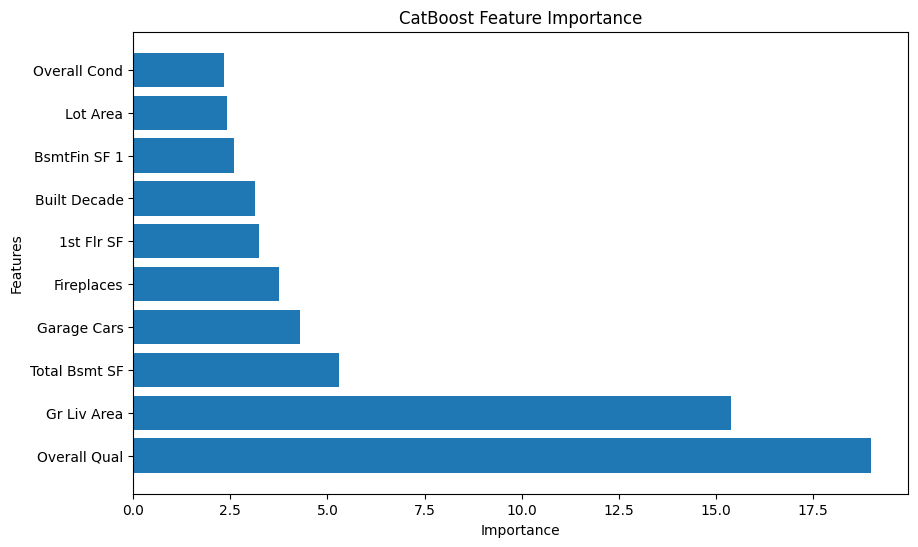

In [16]:
importances = cb_mod.get_feature_importance(type = 'PredictionValuesChange')
feature_importances = pd.Series(importances, index = x.columns).sort_values(ascending = False)[:10]
plt.figure(figsize = (10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()